In [1]:
# TODO:
# how does it behave if only one valid input is given and the rest are generated inputs?
# Demonstrate what lack of training data looks like (len(tr_data) vs. error)
# bit error rate (SNR for analog)
# STDP

# Lorenz
# Noise in testing data and weights


import matplotlib.pyplot as plt
import numpy as np

from snn_dpe.tools.network import create_encoders, create_network

from snn_dpe.tools.train import forward_pass, mse, update_weights
from tqdm import tqdm
from snn_dpe.tools.plotting import *

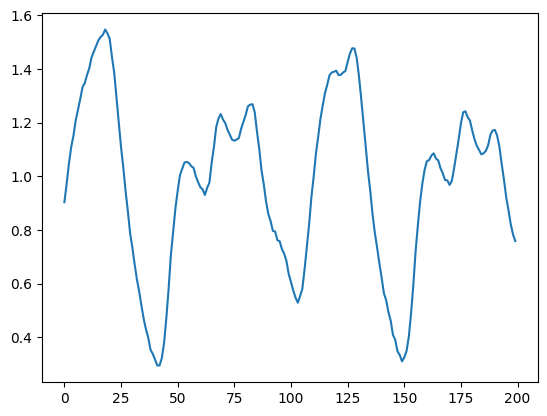

In [10]:
def read_MG_data(filename, normalize=True):
    data = []
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            if i > 0:
                data.append(np.asarray(l.split(','), dtype=np.float64))


    data = np.asarray(data)
    # the actual values are in the second column
    data = data[:,1]
    
    if normalize:
        # maybe we don't need to do this?
        # I don't like this but lets normalize the dataset to values from 0 to 1
        dmin = np.min(data)
        dmax = np.max(data)
        normalized_data = []
        for d in data:
            v = (d - dmin) / (dmax - dmin)
            normalized_data.append(v)

        data = np.asarray(normalized_data)

    return data

# read in training data and plot part of it
MG_data_tr = read_MG_data('./Data/MarkusThill-MGAB-60f6b17/1.csv', normalize=False)
plot_len = 200
plt.plot(range(plot_len), MG_data_tr[:plot_len])

1000


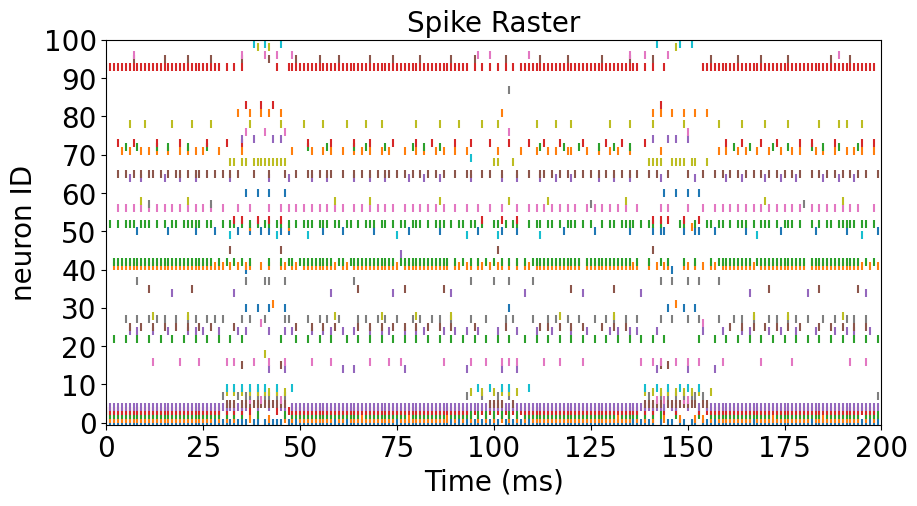

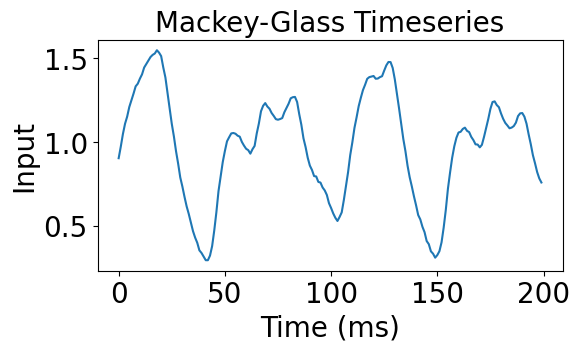

In [15]:
# simulates a network with timeseries data, at each timestep the first n_input neurons receive potentiation in the form of the data
# NOTE: the input neurons are divided evenly into two types. The first get the data normally and the second get an inverted version of the data. 
#   This is done so that the spike raster is not empty in the sections where input is low
# returns - spike raster where the rows correspond to a neuron and each column is a timestep. 
#   If the neuron fired at that timestep there is a 1 otherwise there is a 0
def run_network_timeseries(neurons, data, n_input):
    # simulate
    spike_raster = []
    for i in range(len(data)):
        spike_raster.append([])

    # feed a peice of data in at each timestep
    for t in range(len(data)):
        # get the input for this timestep, and apply it to input neurons
        for i in range(int(n_input/2)): #normal
            neurons[i].apply_potential(data[t])
        for i in range(int(n_input/2)): #inverted
            neurons[i+int(n_input/2)].apply_potential(-data[t]+1)

        # update the network
        for n in neurons:
            if n.update():
                spike_raster[t].append(1)
            else:
                spike_raster[t].append(0)

    return np.asarray(spike_raster)


# create a test network and encoders
n_neurons = 100
synapse_density = 0.1
n_input = 10 #how many neurons will receive potentiation adjustments related to MG
n_synapses = int((n_neurons**2)*synapse_density)
print(n_synapses)

neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.15), weight_factor = 1)


spike_raster = run_network_timeseries(neurons, MG_data_tr[:plot_len], n_input)

plot_fire_matrix(spike_raster)

# plot MG data
fig, ax = plt.subplots(figsize=(6,3))
# ax.set_xlim(0, plot_len)
ax.plot(range(plot_len), MG_data_tr[:plot_len])
ax.tick_params(axis='both', labelsize=20)
ax.set_ylabel('Input', fontsize=20)
ax.set_title('Mackey-Glass Timeseries', fontsize=20)
ax.set_xlabel('Time (ms)', fontsize=20)
plt.show()

In [30]:
# This takes timeseries data and splits it into input and output pairs for training
def generate_io_pairs(timeseries_data, input_window_size, output_window_size, stride = 1):
    TS_inputs = []
    TS_outputs = []

    # iterate over the data in steps of stride while avoiding out of bounds error
    for start_idx in range(0, len(timeseries_data) - input_window_size - output_window_size, stride):

        input_i = timeseries_data[start_idx:start_idx+input_window_size]
        output_i = timeseries_data[start_idx+input_window_size:start_idx+input_window_size+output_window_size]

        TS_inputs.append(input_i)
        TS_outputs.append(output_i)

    return np.asarray(TS_inputs),np.asarray(TS_outputs)

# uses io pairs and an SNN to train a dpe layer
def train_TS(n_epochs, TS_inputs, TS_outputs, neurons, n_input, write_noise_std = 0, TS_inputs_te = None, TS_outputs_te = None, initial_weights = None, initial_bias = None, relative=False):
    if initial_weights == None:
        dpe_weights = np.random.rand(len(neurons), len(TS_outputs[0]))
        dpe_bias = np.random.rand(len(TS_outputs[0]))
    else:
        dpe_weights = initial_weights
        dpe_bias = initial_bias

    # track mean squared errors
    Training_mses = []
    Testing_mses = []
    
    for _ in range(n_epochs):
        # progress bar for each epoch
        pbar = tqdm(TS_inputs)

        mse_avg = 0
        n_processed = 0
        if len(Testing_mses) == 0:
            Testing_mses.append('N/A')

        # iterate over the data
        for input_i, output_i in zip(pbar, TS_outputs):

            # run the network and get the spike raster
            spike_raster = run_network_timeseries(neurons, input_i, n_input)
            for n in neurons:
                n.reset()

            # use the spike raster as an input for the dpe and calculate the result
            x, y = forward_pass(spike_raster, dpe_weights, bias=dpe_bias)

            # relative mode will train the dpe to find the delta from the 
            # last timestep instead of the absolute value
            if relative:
                desired_output = output_i - input_i[-1]
            else:
                desired_output = output_i

            # use gradient descent to update the weights
            update_weights(dpe_weights, x, y, desired_output, bias=dpe_bias)

            dpe_weights += np.random.normal(0, write_noise_std, dpe_weights.shape)
            dpe_bias += np.random.normal(0, write_noise_std, dpe_bias.shape)

            # calculate cumulative average mse
            if mse_avg == 0:
                mse_avg = mse(y, desired_output)
            else:
                mse_avg = (mse(y, desired_output) + n_processed * mse_avg)/ (n_processed+1)

            n_processed += 1
            pbar.set_description(f"Training MSE: {mse_avg:.4}, Testing MSE: {Testing_mses[-1]:.4}")

        Training_mses.append(mse_avg)
        if TS_inputs_te is not None:
            Testing_mse = test_timeseries(TS_inputs_te, TS_outputs_te, neurons, dpe_weights, n_input, bias=dpe_bias, plot_len=0, relative=relative)
            if Testing_mses[-1] == 'N/A':
                Testing_mses[-1] = Testing_mse
            else:
                Testing_mses.append(Testing_mse)

    return Training_mses, Testing_mses, dpe_weights, dpe_bias

# takes inputs of specific window size and calculates outputs for testing then plots if plt_len > 0
def test_timeseries(TS_inputs, TS_outputs, neurons, dpe_weights, n_input, stride=1, TS_data = None, bias = None, relative=False, plot_len = 200):
    
    warmup = len(TS_inputs[0])
    testing_mse = 0

    # for plotting
    dpe_outputs = []
    dpe_time = []
    
    for i, (input_sample, output_sample) in enumerate(zip(TS_inputs, TS_outputs)):
        t = i*stride+warmup

        spike_raster = run_network_timeseries(neurons, input_sample, n_input)

        for n in neurons:
            n.reset()

        _, y = forward_pass(spike_raster, dpe_weights, bias=bias)


        if relative:
            dpe_output = input_sample[-1] + y
        else:
            dpe_output = y

        testing_mse += mse(dpe_output, output_sample)

        if t < plot_len:        
            dpe_time.append(t)
            dpe_outputs.append(dpe_output)


    if plot_len > 0 and TS_data is not None:
        plt.plot(range(len(TS_data))[:plot_len], TS_data[:plot_len])
        plt.plot(dpe_time, dpe_outputs)
        plt.show()

    return testing_mse/len(TS_inputs)

# create a test network
n_neurons = 50
synapse_density = 0.1
n_input = 12 #how many neurons will receive potentiation adjustments related to MG
n_synapses = int((n_neurons**2)*synapse_density)

neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1)

# slice up MG into input, output pairs
input_window_size = 10
output_window_size = 1

n_tr_data = 2000
n_te_data = 2000
MG_inputs_tr, MG_outputs_tr = generate_io_pairs(MG_data_tr[:n_tr_data], input_window_size, output_window_size)

# read data testing
MG_data_te = read_MG_data('./Data/MarkusThill-MGAB-60f6b17/3.csv')
MG_inputs_te, MG_outputs_te = generate_io_pairs(MG_data_te[:n_te_data], input_window_size, output_window_size)

# # probably unnecessary shuffle
# p = np.random.permutation(len(MG_inputs_tr))
# MG_inputs_tr = MG_inputs_tr[p]
# MG_outputs_tr = MG_outputs_tr[p]

n_epochs = 3
# print('training absolute')
# absolute_epoch_mses, absolute_dpe_weights, dpe_bias_absolute = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input)
print('training relative')
training_mses, testing_mses, relative_dpe_weights, dpe_bias_relative = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input, TS_inputs_te=MG_inputs_te, TS_outputs_te=MG_outputs_te, relative=True)



training relative


Training MSE: 0.005618, Testing MSE: 0.101: 100%|██████████| 1989/1989 [00:03<00:00, 657.05it/s]


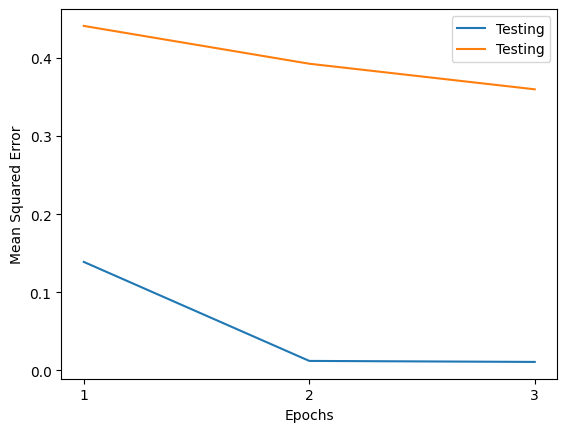

In [29]:
# Training MSE: 0.1579, Testing MSE: N/A: 100%|██████████| 989/989 [00:01<00:00, 507.14it/s]
# Training MSE: 0.02049, Testing MSE: 0.4389: 100%|██████████| 989/989 [00:01<00:00, 533.72it/s]
# # Training MSE: 0.01497, Testing MSE: 0.3332: 100%|██████████| 989/989 [00:01<00:00, 522.47it/s]

# plt.plot(range(n_epochs), absolute_epoch_mses, label='absolute')
plt.plot(range(n_epochs), training_mses, label='Testing')
plt.plot(range(n_epochs), testing_mses, label='Testing')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.xticks(range(n_epochs), labels = range(1, n_epochs+1))
plt.legend()
plt.show()

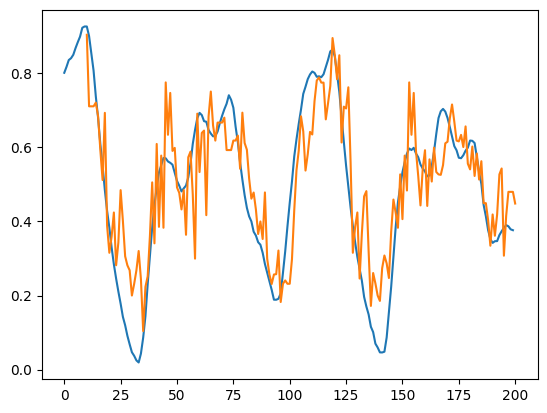

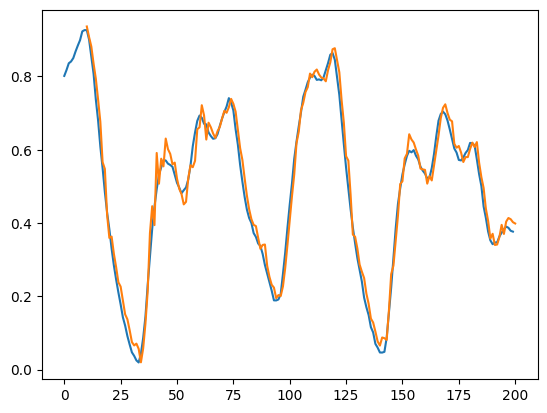

In [11]:


# test_timeseries(MG_data_te, MG_inputs_te, neurons, absolute_dpe_weights, bias = dpe_bias_absolute)
test_timeseries(MG_data_te, MG_inputs_te, neurons, relative_dpe_weights, n_input, bias = dpe_bias_relative, relative=True)
